In [50]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import trapz, cumtrapz
import os
from scipy.integrate import cumtrapz
from scipy.optimize import root_scalar, minimize_scalar, minimize
from scipy.stats import chi2

from constants import e_egb, err_high_egb, n_u_0, n_mw_pbhs
from diffuse_constraints import phi_ex
from posterior_inference_shared import Distribution_f, f_min, f_max
from posterior_inference_point import PointSourcePosterior, Distribution_N_gamma
from posterior_inference_diffuse import DiffusePosterior

colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]

In [51]:
m_pbh = 0.5
n_pbh = 1
n_u = 19

# Point source limits

In [55]:
alpha = 0.95
0.5 * chi2.ppf(alpha / 2, 2*n_u_0), 0.5 * chi2.ppf(1 - alpha / 2, 2*n_u_0 + 2)

(18.39850674913452, 19.946682005618857)

In [83]:
@np.vectorize
def point_source_limit(m_dm, m_pbh, n_pbh, merger_rate_prior="LF", alpha=0.95, f_percentile=0.05):
    # Get f value corresponding to percentile
    p_f = Distribution_f(m_pbh, n_pbh, merger_rate_prior)
    f = p_f.inverse_cdf(f_percentile)
    
    p_n_gamma = Distribution_N_gamma(m_pbh)
    p_value = 1 - alpha
    
    @np.vectorize
    def func(log10_sv):
        # Compute Pr(N_gamma >= 19) = 1 - Pr(N_gamma < 19)
        cdf = 1 - p_n_gamma(np.arange(0, n_u_0), 10**log10_sv, f, m_dm).sum()
        return (cdf - p_value)**2

    # Find good bracketing interval
    log10_svs = np.linspace(-44, -23, 100)
    idx_a, idx_b = np.where(func(log10_svs) / p_value**2 < 0.9999)[0][[0, -1]]

    res = minimize(func, x0=np.mean(log10_svs[[idx_a, idx_b]]),
                   bounds=[[log10_svs[idx_a], log10_svs[idx_b]]])
    assert res.success
    return 10**res.x[0]

In [76]:
m_dms = np.logspace(1, 4, 30)
sv_lims_ps = point_source_limit(m_dms, m_pbh, n_pbh)

Text(0, 0.5, '$f^4 \\langle \\sigma v \\rangle$ (cm$^3$/s)')

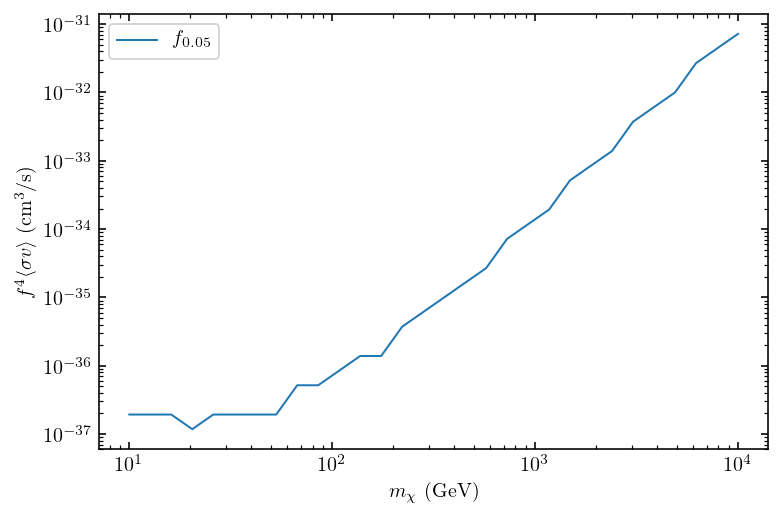

In [77]:
plt.loglog(m_dms, sv_lims_ps, label=r"$f_{0.05}$")

plt.legend()
plt.xlabel(r"$m_\chi$ (GeV)")
plt.ylabel(r"$f^4 \langle \sigma v \rangle$ (cm$^3$/s)")

# Diffuse limits

In [43]:
chi2_crit = 38.9

@np.vectorize
def diffuse_limit(m_dm, m_pbh, n_pbh, merger_rate_prior="LF", f_percentile=0.05):
    sv_ref = 3e-26

    # Get f value corresponding to percentile
    p_f = Distribution_f(m_pbh, n_pbh, merger_rate_prior)
    f = p_f.inverse_cdf(f_percentile)

    # Compute chi2 for each of these
    chi2_ref = np.sum((phi_ex(e_egb, m_dm, sv_ref, m_pbh, f) /
                        err_high_egb)**2)

    return sv_ref * (chi2_crit / chi2_ref)**(3/2)

In [44]:
m_dms = np.logspace(1, 4, 30)
sv_lims_diff = diffuse_limit(m_dms, m_pbh, n_pbh)

Text(0, 0.5, '$f^4 \\langle \\sigma v \\rangle$ (cm$^3$/s)')

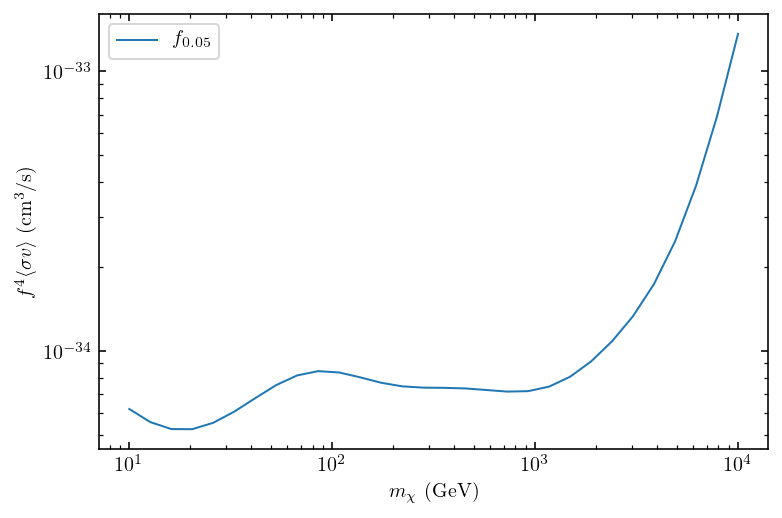

In [45]:
plt.loglog(m_dms, sv_lims_diff, label=r"$f_{0.05}$")

plt.legend()
plt.xlabel(r"$m_\chi$ (GeV)")
plt.ylabel(r"$f^4 \langle \sigma v \rangle$ (cm$^3$/s)")

# Combine limit plot

In [96]:
m_dms = np.logspace(1, 4, 30)
f_percentile = 0.05

### Setup
n_pbhs = np.array([[1,  1,     10],
                   [80, 24000, 80]]).T
m_pbhs = np.array([[0.5, 10, 100],
                   [0.5, 10, 100]]).T

# LIGO's prior ("J" or "LF")
merger_rate_prior = "J" 

# sigma-v prior ("U" or "LF")
sv_prior = "U"

# BSM 95% contours
gambit_dir = "data/gambit/"
gambit_models = ["CMSSM", "MSSM7", "NUHM1", "NUHM2"]#, "SingletDM"]
gambit_grid_rows, gambit_grid_cols = 101, 203

# Colors
pbh_colors = {0.5: colors[0], 10: colors[1], 100: colors[2]}

def plot_gambit_contour_envelope(ax, color=None, padding=10, level=6):
    # TODO: Christoph said 3, not 6...
    # Construct parameter meshgrid
    m_dm_g = np.logspace(1, 4, gambit_grid_cols)[padding:]
    sv_g = np.logspace(-45, -23, gambit_grid_rows)[padding:]
    m_dm_g_mg, sv_g_mg = np.meshgrid(m_dm_g, sv_g)

    #Add the singlet contour separately
    singlet_contour = np.load(
            "{}contours_SingletDM.npy".format(gambit_dir)).T[padding:, padding:]
    ax.contourf(m_dm_g_mg, sv_g_mg, singlet_contour, levels=[0, level], alpha=0.2,
                colors=[color])
    
    # Construct envelope of contours
    envelope = np.inf * np.ones([gambit_grid_rows - padding, gambit_grid_cols - padding])
    for model in gambit_models:
        gambit_data = np.load(
            "{}contours_{}.npy".format(gambit_dir, model)).T#[padding:, padding:]
        
        gambit_contour = gambit_data[padding:, padding:]
        envelope = np.min([envelope, gambit_contour], axis=0)
    
    ax.contourf(m_dm_g_mg, sv_g_mg, envelope, levels=[0, level], alpha=0.35,
                colors=[color])

In [99]:
for i in range(n_pbhs.shape[0]):
    for j in range(n_pbhs.shape[1]):
        m_pbh = m_pbhs[i, j]
        n_pbh = n_pbhs[i, j]
        
        print(m_pbh, n_pbh, Distribution_f(m_pbh, n_pbh, "LF").inverse_cdf(0.05))

0.5 1 0.0014935021332963395
0.5 80 0.10951749830243622
10.0 1 7.280901891299522e-06
10.0 24000 0.004171887405273802
100.0 10 2.5615332966411575e-05
100.0 80 0.00033352864834522726


In [100]:
for i in range(n_pbhs.shape[0]):
    for j in range(n_pbhs.shape[1]):
        m_pbh = m_pbhs[i, j]
        n_pbh = n_pbhs[i, j]
        
        print(m_pbh, n_pbh, Distribution_f(m_pbh, n_pbh, "J").inverse_cdf(0.05))

0.5 1 0.002800561607084211
0.5 80 0.10996349102765948
10.0 1 1.3241851804501053e-05
10.0 24000 0.0041719254495327885
100.0 10 2.8211754555819063e-05
100.0 80 0.0003360247441263414


In [ ]:
fig, axes = plt.subplots(n_pbhs.shape[0], n_pbhs.shape[1], sharex=True, sharey=True,
                         figsize=(6, 7))


for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        m_pbh = m_pbhs[i, j]
        n_pbh = n_pbhs[i, j]
        
        for prior, ls in zip(["J", "LF"], ['-', '-.']):
            # Diffuse limit
            lab = "Diffuse" if prior == "J" else ""
            sv_diff_bounds = diffuse_limit(m_dms, m_pbh, n_pbh, prior)
            ax.loglog(m_dms, sv_diff_bounds, label=lab, linestyle=ls, color=colors[2])

            # Point source limit
            lab = "Point source" if prior == "J" else ""
            sv_ps_bounds = point_source_limit(m_dms, m_pbh, n_pbh, prior)
            ax.loglog(m_dms, sv_ps_bounds, label=lab, linestyle=ls, color=colors[3])
        
        # BSM physics contours
        plot_gambit_contour_envelope(ax, 'k')
        # Thermal relic cross section
        ax.axhline(3e-26, linestyle='--', color='k', alpha=0.6, linewidth=0.75)

        # Formatting
        ax.set_xlim(m_dms[[0, -1]])
        ax.set_ylim(1e-44, 1e-23)
        ax.set_title(r"$(M_{\mathrm{PBH}}, N_{\mathrm{PBH}}) = $" +
                     "({:g} $M_\odot$, {:d})".format(m_pbh, n_pbh), fontsize=9.0)
        if i == axes.shape[0] - 1:
            ax.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=12)
        if j == 0:
            ax.set_ylabel(r"$f_{\chi}{}^4 (\sigma v)_0$ (cm$^3$/s)", fontsize=12)
        if i == 0 and j == 0:
            ax.plot([1e-50, 1e-50], [1e-50, 1e-50], color='k', linestyle='-', label='Jeffreys Rate Prior')
            ax.plot([1e-50, 1e-50], [1e-50, 1e-50], color='k', linestyle='-.', label='Log-flat Rate Prior')
            ax.legend(fontsize=7)

fig.tight_layout()
fig.savefig("figures/frequentist_sv_limits_ps_diff_comparison.pdf",
            bbox_inches='tight', pad_inches=0.05)

In [192]:
os.system("say 'done'")

0

# Scratch

In [ ]:
@np.vectorize
def point_source_limit(m_dm, m_pbh, n_pbh, merger_rate_prior="LF", alpha=0.95, f_percentile=0.05):
    p_n_gamma = Distribution_N_gamma(m_pbh)
    # Get f value corresponding to percentile
    p_f = Distribution_f(m_pbh, n_pbh, merger_rate_prior)
    f = p_f.inverse_cdf(f_percentile)
    # Convert N_U=19 observations into an upper bound on p_gamma using the Poisson
    # approximation to the binomial distribution and the confidence interval for its
    # rate
    p_gamma_u = 0.5 * chi2.ppf(1 - alpha / 2, 2*n_u_0 + 2) / n_mw_pbhs(f, m_pbh)
    print(p_gamma_u)
    
    def func(log10_sv):
        return (p_n_gamma.p_gamma(10**log10_sv, m_dm) - p_gamma_u)**2
    
#     @np.vectorize
#     def func(log10_sv):
#         # Compute Pr(N_gamma >= 19) = 1 - Pr(N_gamma < 19)
#         cdf = p_n_gamma(np.arange(0, n_u_0), 10**log10_sv, f, m_dm)
#         return ((1 - cdf.sum()) - alpha)**2

    # Find good bracketing interval
    log10_svs = np.linspace(-44, -23, 50)
    idx_a, idx_b = np.where(func(log10_svs))[0][[0, -1]]
    print(func(log10_svs))

    res = minimize(func, x0=np.mean(log10_svs[[idx_a, idx_b]]),
                   bounds=[[log10_svs[idx_a], log10_svs[idx_b]]])
    assert res.success
    return 10**res.x[0]

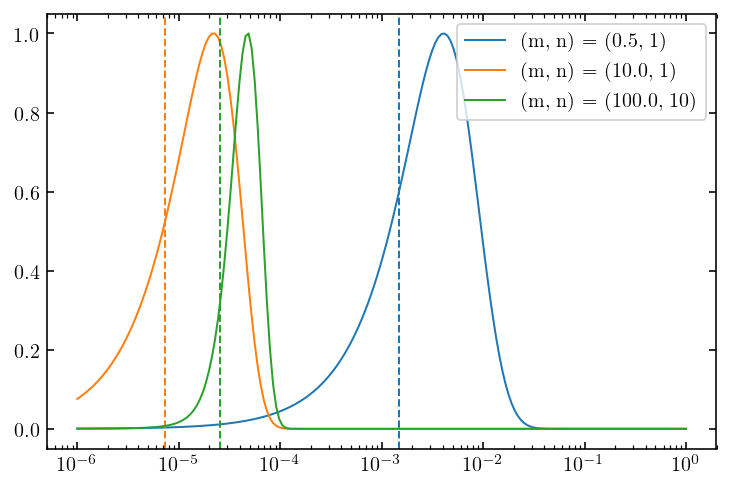

In [93]:
fs = np.geomspace(1e-6, 1e0, 200)
m_pbhs = np.array([0.5, 10, 100])
n_pbhs = np.array([1, 1, 10])

for m_pbh, n_pbh, c in zip(m_pbhs, n_pbhs, colors):
    p_f = Distribution_f(m_pbh, n_pbh, "LF")
    p_f_vals = p_f(fs)
    plt.plot(fs, p_f_vals / p_f_vals.max(), label="(m, n) = ({}, {})".format(p_f.m_pbh, p_f.n_pbh),
             color=c)
    plt.axvline(p_f.inverse_cdf(0.05), color=c, linestyle="--")

plt.xscale("log")
plt.legend()